## Machine Learning - Assignment No. 3

### Part 1 – Aim: ANN from Scratch 

###2) Neural Network with two hidden layers - ch11 revised

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [1]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [2]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

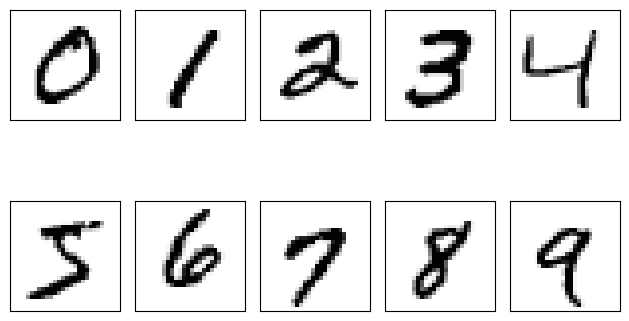

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

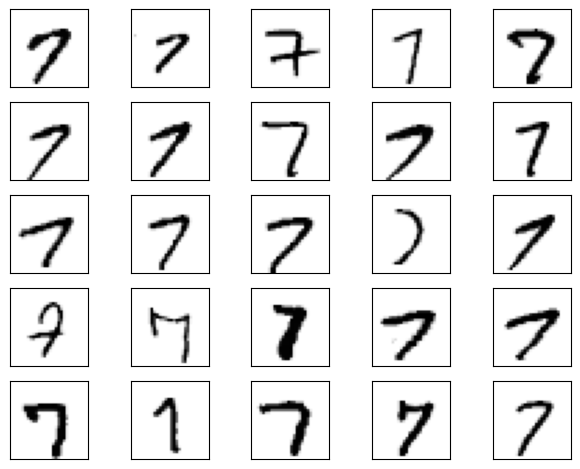

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

<br>
<br>

## Implementing a multi-layer perceptron

In [5]:
import numpy as np

In [6]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_hidden2, num_classes, 
                 random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # revision - hidden layer 2
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden))
        self.bias_h2 = np.zeros(num_hidden2)        
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # revision - hidden layer 2
        # input dim: [n_examples, n_hidden] dot [n_hidden2, n_hidden].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden2] dot [n_classes, n_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_h2, a_out

    def backward(self, x, a_h, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden2]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden2]
        # output dim: [n_classes, n_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # Hidden layer 2
        # [n_classes, n_hidden2]
        d_z_out__a_h2 = self.weight_out
        
        # output dim: [n_examples, n_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden2]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative
        # [n_examples, n_hidden2]
        delta_h2 = d_loss__a_h2 * d_a_h__d_z_h2
        
        # [n_examples, n_hidden]
        d_z_h__d_w_h2 = a_h
        
        # output dim: [n_hidden2, n_hidden]
        d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h__d_w_h2)
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)

        # Hidden layer 1 
        # [n_hidden2, n_hidden]
        d_z_out__a_h = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_h2, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h, d_loss__d_b_h)

###3) Apply the code of section 2 with the two layers for classifying handwritten digits MNIST dataset using the same full ANN architecture presented in the class and evaluate its prediction performance (macro AUC) using Train(70%)/Test(30%) validation procedure. 

In [7]:
# Model in class - input dims = 28*28, num_hidden = 500 & num_hidden2 = 500
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     num_hidden2=500,
                     num_classes=10)

Split into training, validation, and test set:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

# optional to free up some memory by deleting non-used arrays:
del X, y

## Coding the neural network training loop

Defining data loaders:

In [9]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [10]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, _, probas = model.forward(X_test)
mse = mse_loss(y_test, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_test, predicted_labels)

print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 9.9%


In [11]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [12]:
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 9.9%


In [13]:
def train(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
        train_acc, test_acc = train_acc*100, test_acc*100
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_test_acc

In [14]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc = train(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.03 | Train Acc: 84.89% | Test Acc: 84.79%
Epoch: 002/050 | Train MSE: 0.02 | Train Acc: 87.68% | Test Acc: 87.52%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.33% | Test Acc: 89.26%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.20% | Test Acc: 90.00%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.85% | Test Acc: 90.58%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.35% | Test Acc: 91.10%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.86% | Test Acc: 91.54%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 92.09% | Test Acc: 91.68%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.37% | Test Acc: 92.04%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.54% | Test Acc: 92.09%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 93.03% | Test Acc: 92.58%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 93.18% | Test Acc: 92.67%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 93.44% | Test Acc: 92.88%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.81% | Test Acc:

## Evaluating the neural network performance

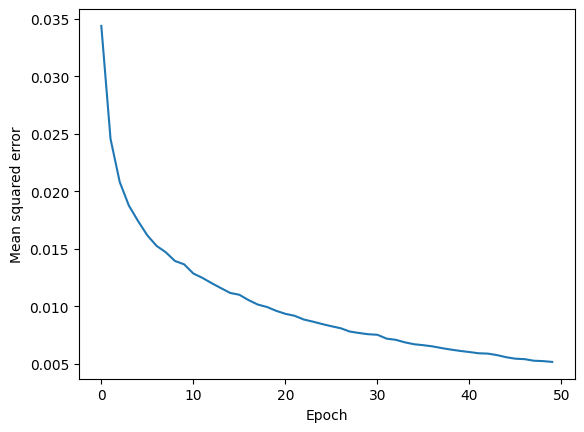

In [15]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

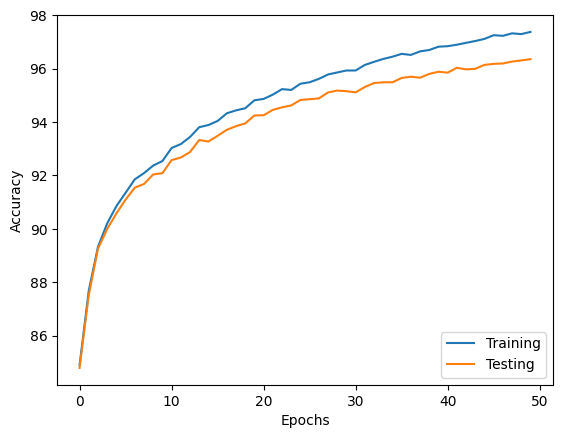

In [16]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [17]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.36%


In [18]:
from sklearn.metrics import roc_auc_score

def compute_auc(nnet, X, y, num_labels=10, minibatch_size=100):
    aucs = []
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        aucs.append(roc_auc_score(onehot_targets, probas, average='macro', 
                                  multi_class='ovo'))
    return np.mean(aucs)

test_auc = compute_auc(model, X_test, y_test)
print(f'Test macro AUC: {test_auc*100:.2f}%')

Test macro AUC: 99.67%


Plot failure cases:

In [19]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

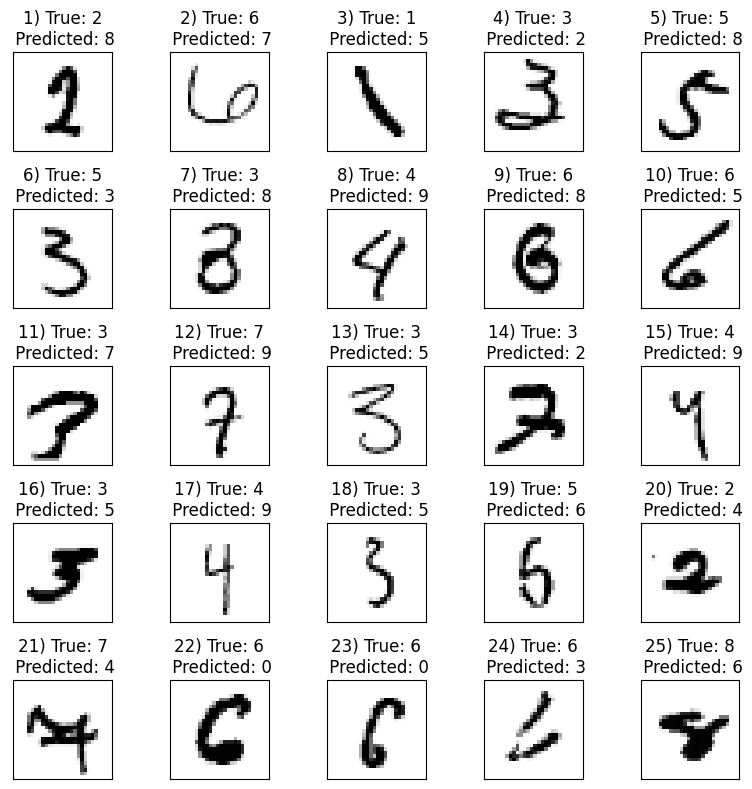

In [20]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

###4) Compare the predictive performance of section 3 with the original (single hidden layer) code and with the fully connected ANN implemented in Keras/TensorFlow/PyTorch (choose one).

*   The original ANN architecture with single hidden layer in **ch11 scored Test accuracy: 94.54%** with 50 epoches compared to **Test accuracy: 96.36%** achieved by the two-hidden-layer ANN architecture with the same number of epochs. Additionally the model with two-hidden-layers achieved **Test macro AUC: 99.65%**
*   Next, compare a fully connected ANN implemented in Keras (TensorFlow). In this implemenation a different optimizer was used (rmsprop) to achieve similar results for the same model architecture, as SGD optimizer was unable to converge within the same number of epochs.

In [22]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(500, activation='sigmoid', input_shape=(28*28,)),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='mean_squared_error',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

history = model.fit(X_train, keras.utils.to_categorical(y_train),
                    batch_size=100, epochs=50, verbose=1,
                    validation_data=(X_test, keras.utils.to_categorical(y_test)), 
                    callbacks=[early_stopping])

Epoch 1/50
490/490 [==============================] - 11s 21ms/step - loss: 0.0509 - accuracy: 0.6386 - val_loss: 0.0227 - val_accuracy: 0.8625
Epoch 2/50
490/490 [==============================] - 9s 17ms/step - loss: 0.0182 - accuracy: 0.8843 - val_loss: 0.0160 - val_accuracy: 0.8973
Epoch 3/50
490/490 [==============================] - 10s 20ms/step - loss: 0.0148 - accuracy: 0.9039 - val_loss: 0.0142 - val_accuracy: 0.9083
Epoch 4/50
490/490 [==============================] - 9s 19ms/step - loss: 0.0134 - accuracy: 0.9130 - val_loss: 0.0129 - val_accuracy: 0.9150
Epoch 5/50
490/490 [==============================] - 8s 17ms/step - loss: 0.0123 - accuracy: 0.9197 - val_loss: 0.0121 - val_accuracy: 0.9204
Epoch 6/50
490/490 [==============================] - 9s 19ms/step - loss: 0.0115 - accuracy: 0.9245 - val_loss: 0.0119 - val_accuracy: 0.9232
Epoch 7/50
490/490 [==============================] - 10s 20ms/step - loss: 0.0108 - accuracy: 0.9299 - val_loss: 0.0112 - val_accuracy: 0.9

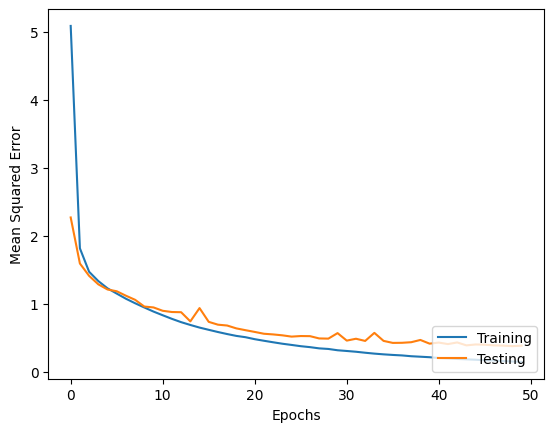

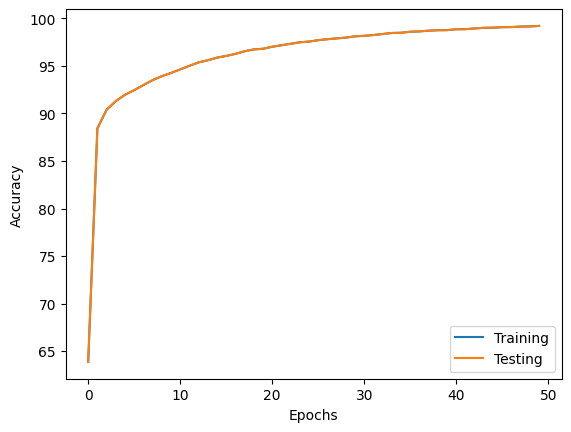

In [26]:
training_loss = np.array(history.history['loss']) * 100
testing_loss = np.array(history.history['val_loss']) * 100

plt.plot(training_loss, label='Training')
plt.plot(testing_loss, label='Testing')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

training_accuracy = np.array(history.history['accuracy']) * 100
testing_accuracy = np.array(history.history['val_accuracy']) * 100

plt.plot(training_accuracy, label='Training')
plt.plot(training_accuracy, label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, keras.utils.to_categorical(y_test))
print(f'Test accuracy: {test_accuracy*100:.2f}%')

657/657 [==============================] - 4s 6ms/step - loss: 0.0039 - accuracy: 0.9750
Test accuracy: 97.50%


In [28]:
y_pred = model.predict(X_test)

# Calculate AUC-macro score
test_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovo')
print(f'Test macro AUC: {test_auc*100:.2f}%')

657/657 [==============================] - 3s 4ms/step
Test macro AUC: 99.92%


The Keras implementation of the model achieved **Test accuracy: 97.50%**
 and **Test macro AUC: 99.92%** compared to **Test accuracy: 96.36%** and **Test macro AUC: 99.65%** scored by the revised ch11 implementation